In [22]:
using IJulia
using Distributions
using DataFrames
using CSV
using Tables
using GLM
using CovarianceMatrices
using Gadfly
using Statistics
using Markdown

ArgumentError: ArgumentError: Package IJulia not found in current path.
- Run `import Pkg; Pkg.add("IJulia")` to install the IJulia package.

In [2]:
include("../julia_notebooks/hdmjl/hdmjl.jl")

In [3]:
function simulate_once(seed)
    Random.seed!(seed)
    n = 100
    p = 100
    beta = 1 ./ (1:p) .^ 2  # Note the use of ./ for element-wise division
    gamma = 1 ./ (1:p) .^ 2

    X = rand(Normal(0, 1), n, p)
    D = X * gamma .+ (rand(Normal(0, 1), n, 1) / 4)  # Note the use of .+ for element-wise addition
    Y = 10 * D .+ X * beta .+ rand(Normal(0, 1), n, 1)  # Note the use of .+ for element-wise addition

    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D, X)
    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )
    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        naive_coef = coef(lm(@formula(Y ~ D), Y1))[2]
    end
    if (sum(coef1[SX_IDs,:])>0) 
        Y2 = hcat(Y, D)
        for i in 1:length(SX_IDs)
            col_name = Symbol("X$SX_IDs[i]")
            Y2[!, col_name] = X[!, SX_IDs[i]]
        end
        formula = Term(:Y) ~ Term(:D) + sum(Term(Symbol("X$SX_IDs[i]")) for i in 1:length(SX_IDs))
        naive_coef = coef(lm(formula, Y2))[2]
    end

    model2 =rlasso_arg( X, Y ,nothing, true, true, true, false, false, 
        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, true, true, true, false, false, 
        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true );

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    orthogonal_coef = coef(lm(@formula(resY ~ resD), Y3))[2]

    return naive_coef, orthogonal_coef
end


simulate_once (generic function with 1 method)

In [4]:
simulate_once(0)

(10.908754441475432, 9.991524145807752)

In [5]:
function run_simulation(B)
    results = pmap(simulate_once, 1:B)
    Naive = [result[1] for result in results]
    Orthogonal = [result[2] for result in results]
    return Naive, Orthogonal
end

run_simulation (generic function with 1 method)

In [6]:
Orto_breaks = 8:0.2:12
Naive_breaks = 8:0.2:12

8.0:0.2:12.0

In [7]:
function create_histogram_data(data, breaks)
    counts, edges = fit(Histogram, data, breaks).weights, breaks
    midpoints = (edges[1:end-1] .+ edges[2:end]) ./ 2
    return DataFrame(midpoints = midpoints, counts = counts ./ sum(counts) ./ 0.2)  # Normalized to density
end

create_histogram_data (generic function with 1 method)

### Simulated with 100 Iterations

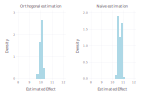

Time taken for 100 iteration simulation: 5.78 seconds

Time taken for 1000 iteration simulation: 56.9 seconds

Time taken for 10000 iteration simulation: 741.64 seconds



### Simulated with 1000 Iterations

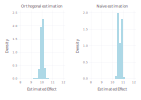

### Simulated with 10000 Iterations

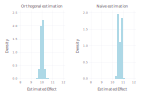

In [21]:
Bs = [100, 1000]
for B in Bs
    start_time = time()
    Naive, Orthogonal = run_simulation(B)
    end_time = time()
    elapsed_time = end_time - start_time  # Calculate elapsed time
    
    naive_hist = create_histogram_data(Naive, Naive_breaks)
    ortho_hist = create_histogram_data(Orthogonal, Orto_breaks)

    naive_plot = plot(naive_hist, 
        x = :midpoints, y = :counts, Geom.bar,
        Guide.xlabel("Estimated Effect"), Guide.ylabel("Density"),
        Coord.cartesian(xmin=8, xmax=12),
        Theme(default_color=color("lightblue"), 
              panel_fill=color("white"),
              background_color=color("white")),
        Guide.title("Naive estimation")
    )
    
    ortho_plot = plot(ortho_hist, 
        x = :midpoints, y = :counts, Geom.bar,
        Guide.xlabel("Estimated Effect"), Guide.ylabel("Density"),
        Coord.cartesian(xmin=8, xmax=12),
        Theme(default_color=color("lightblue"), 
              panel_fill=color("white"),
              background_color=color("white")),
        Guide.title("Orthogonal estimation")
    )
    
    # Combine the plots side by side
    combined_plot = hstack(ortho_plot, naive_plot)
    
    # Display the title and combined plots in a Jupyter notebook
    println("Time taken for $B iteration simulation: $(round(elapsed_time, digits=2)) seconds\n")
    display("text/markdown","### Simulated with $B Iterations")
    display(combined_plot)
    
    
end
